# Load Library


In [ ]:
# =========================
# 1) Imports (Core)
# =========================
import os
import time
import numpy as np

import torch
import torch.nn.functional as F

from scipy.stats import spearmanr

# =========================
# 2) Project Imports
# =========================
from PIA import PIA
from utils import get_batch_optimized, hybrid_fit

print("✅ Imports OK")


✅ Imports OK


In [2]:
noisy, f, Dt, Ds, clean = get_batch_new(batch_size=64, noise_sdt=0.05, normalize_b0=True)
print("noisy b0 mean/std:", noisy[:,0].mean().item(), noisy[:,0].std().item())
print("clean b0 mean/std:", clean[:,0].mean().item(), clean[:,0].std().item())

noisy b0 mean/std: 1.0 0.0
clean b0 mean/std: 1.0 0.0


## Generate batches for different sigmas

In [2]:
# =========================
# 3) Generate batches for different sigmas
# =========================
sigmas = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]

N = 2500  # batch size per sigma (istersen 500/1000 yapıp hızlı deneyebilirsin)

batches = {}  # sigma -> dict of tensors

for s in sigmas:
    noisy, f_gt, Dt_gt, Dstar_gt, clean = get_batch_new(N, noise_sdt=s, normalize_b0=False)

    batches[s] = {
        "noisy": noisy,         # torch tensor [N, 8]
        "clean": clean,         # torch tensor [N, 8] (istersen kullanırsın)
        "f_gt": f_gt.view(-1),  # [N]
        "Dt_gt": Dt_gt.view(-1),
        "Dstar_gt": Dstar_gt.view(-1),
    }

    # hızlı sanity-check (ölçekleri görmek için)
    print(
        f"sigma={s:>7.1e} | noisy={tuple(noisy.shape)} "
        f"| f[{batches[s]['f_gt'].min():.3f},{batches[s]['f_gt'].max():.3f}] "
        f"Dt[{batches[s]['Dt_gt'].min():.3f},{batches[s]['Dt_gt'].max():.3f}] "
        f"D*[{batches[s]['Dstar_gt'].min():.3f},{batches[s]['Dstar_gt'].max():.3f}]"
    )

print("\n✅ Batches generated.")


sigma=1.0e-06 | noisy=(2500, 8) | f[0.001,1.000] Dt[0.000,2.899] D*[0.003,59.957]
sigma=5.0e-06 | noisy=(2500, 8) | f[0.001,0.999] Dt[0.001,2.899] D*[0.005,59.936]
sigma=1.0e-05 | noisy=(2500, 8) | f[0.000,0.999] Dt[0.001,2.899] D*[0.023,59.997]
sigma=5.0e-05 | noisy=(2500, 8) | f[0.000,1.000] Dt[0.000,2.893] D*[0.007,59.997]
sigma=1.0e-04 | noisy=(2500, 8) | f[0.000,0.999] Dt[0.000,2.900] D*[0.062,59.999]
sigma=5.0e-04 | noisy=(2500, 8) | f[0.000,0.999] Dt[0.002,2.897] D*[0.001,59.995]
sigma=1.0e-03 | noisy=(2500, 8) | f[0.000,0.999] Dt[0.002,2.896] D*[0.012,59.973]
sigma=5.0e-03 | noisy=(2500, 8) | f[0.000,1.000] Dt[0.003,2.899] D*[0.015,59.965]
sigma=1.0e-02 | noisy=(2500, 8) | f[0.000,1.000] Dt[0.000,2.898] D*[0.031,59.967]
sigma=5.0e-02 | noisy=(2500, 8) | f[0.000,0.999] Dt[0.001,2.900] D*[0.030,59.984]
sigma=1.0e-01 | noisy=(2500, 8) | f[0.000,1.000] Dt[0.001,2.897] D*[0.001,59.969]
sigma=5.0e-01 | noisy=(2500, 8) | f[0.000,1.000] Dt[0.001,2.899] D*[0.003,59.973]

✅ Batches gener

## Hybrid fit for each sigma (usıng stored batches)

In [3]:
# =========================
# 4) NLLS / Hybrid fit for each sigma (using stored batches)
# =========================
nlls_preds = {}   # sigma -> dict of numpy arrays
nlls_times = {}   # sigma -> seconds

for s in sigmas:
    x = batches[s]["noisy"]               # torch [N,8]
    x_np = x.detach().cpu().numpy()       # numpy [N,8]

    t0 = time.time()
    f_pred, Dt_pred, Dstar_pred = hybrid_fit(x_np)
    t1 = time.time()

    # numpy'ya ve 1D şekle zorlayalım
    f_pred = np.asarray(f_pred).reshape(-1)
    Dt_pred = np.asarray(Dt_pred).reshape(-1)
    Dstar_pred = np.asarray(Dstar_pred).reshape(-1)

    nlls_preds[s] = {
        "f": f_pred,
        "Dt": Dt_pred,
        "Dstar": Dstar_pred
    }
    nlls_times[s] = (t1 - t0)

    print(
        f"sigma={s:>7.1e} | time={nlls_times[s]:6.2f}s | "
        f"f[{f_pred.min():.3f},{f_pred.max():.3f}] "
        f"Dt[{Dt_pred.min():.3f},{Dt_pred.max():.3f}] "
        f"D*[{Dstar_pred.min():.3f},{Dstar_pred.max():.3f}]"
    )

print("\n✅ NLLS predictions stored in: nlls_preds[sigma]")


sigma=1.0e-06 | time=  9.60s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,59.955]
sigma=5.0e-06 | time= 11.91s | f[0.000,0.999] Dt[0.001,2.898] D*[3.000,59.937]
sigma=1.0e-05 | time= 10.82s | f[0.000,0.999] Dt[0.001,2.899] D*[3.000,60.000]
sigma=5.0e-05 | time=  9.56s | f[0.000,0.999] Dt[0.000,2.895] D*[3.000,59.992]
sigma=1.0e-04 | time=  7.41s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,59.999]
sigma=5.0e-04 | time=  5.47s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,60.000]
sigma=1.0e-03 | time=  5.59s | f[0.000,0.999] Dt[0.000,2.900] D*[3.000,60.000]
sigma=5.0e-03 | time=  6.08s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,60.000]
sigma=1.0e-02 | time=  6.16s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,60.000]
sigma=5.0e-02 | time=  7.03s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,60.000]
sigma=1.0e-01 | time=  6.61s | f[0.000,1.000] Dt[0.000,2.900] D*[3.000,60.000]
sigma=5.0e-01 | time=  6.87s | f[0.000,0.867] Dt[0.000,1.814] D*[3.000,60.000]

✅ NLLS predictions stored in: nlls_preds[sigma]


## Load PIA + predict for each sigma

In [1]:
device = torch.device("cpu")
PATH = 'pia_runs/Expert_HighNoise_v1/best_checkpoint.pt'

ckpt = torch.load(PATH, map_location=device)
print("Checkpoint type:", type(ckpt))

if isinstance(ckpt, dict):
    print("Checkpoint keys:", list(ckpt.keys()))
else:
    print("Checkpoint is not a dict (likely raw state_dict).")

# state_dict seç
state_dict = ckpt["model_state_dict"] if (isinstance(ckpt, dict) and "model_state_dict" in ckpt) else ckpt

# predictor_depth seç (önce ckpt, yoksa fallback)
pred_depth = 6
if isinstance(ckpt, dict) and "args" in ckpt and isinstance(ckpt["args"], dict):
    pred_depth = ckpt["args"].get("predictor_depth", pred_depth)

print("Using predictor_depth =", pred_depth)

model = PIA(predictor_depth=pred_depth, device=device).to(device)

# yükle
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", len(missing))
print("Unexpected keys:", len(unexpected))

# Eğer missing/unexpected 0 ise artık strict=True bile olurdu.
model.eval()
print("✅ Model loaded (strict=False). If missing/unexpected are 0, you're perfectly matched.")


NameError: name 'torch' is not defined

## PIA predictions for each sigma (store in RAM)

In [40]:
# =========================
# 6) PIA predictions for each sigma (store in RAM)
# =========================
pia_preds = {}   # sigma -> dict of numpy arrays
pia_times = {}   # sigma -> seconds

with torch.no_grad():
    for s in sigmas:
        x = batches[s]["noisy"].to(device)  # torch [N,8]

        t0 = time.time()
        f_p, Dt_p, Dstar_p = model.encode(x)
        t1 = time.time()

        f_p = f_p.view(-1).cpu().numpy()
        Dt_p = Dt_p.view(-1).cpu().numpy()
        Dstar_p = Dstar_p.view(-1).cpu().numpy()

        pia_preds[s] = {"f": f_p, "Dt": Dt_p, "Dstar": Dstar_p}
        pia_times[s] = (t1 - t0)

        print(
            f"sigma={s:>7.1e} | time={pia_times[s]:6.4f}s | "
            f"f[{f_p.min():.3f},{f_p.max():.3f}] "
            f"Dt[{Dt_p.min():.3f},{Dt_p.max():.3f}] "
            f"D*[{Dstar_p.min():.3f},{Dstar_p.max():.3f}]"
        )

print("\n✅ PIA predictions stored in: pia_preds[sigma]")


sigma=1.0e-06 | time=0.0957s | f[0.035,0.986] Dt[0.012,2.801] D*[0.288,57.370]
sigma=5.0e-06 | time=0.0897s | f[0.046,0.985] Dt[0.024,2.800] D*[0.287,57.428]
sigma=1.0e-05 | time=0.0896s | f[0.029,0.986] Dt[0.007,2.798] D*[0.284,57.427]
sigma=5.0e-05 | time=0.0890s | f[0.037,0.985] Dt[0.015,2.801] D*[0.282,57.371]
sigma=1.0e-04 | time=0.0864s | f[0.037,0.986] Dt[0.020,2.795] D*[0.290,57.278]
sigma=5.0e-04 | time=0.0892s | f[0.039,0.986] Dt[0.022,2.801] D*[0.286,57.354]
sigma=1.0e-03 | time=0.1009s | f[0.039,0.986] Dt[0.024,2.803] D*[0.274,57.360]
sigma=5.0e-03 | time=0.1054s | f[0.032,0.987] Dt[0.010,2.800] D*[0.228,57.367]
sigma=1.0e-02 | time=0.1005s | f[0.030,0.986] Dt[0.005,2.807] D*[0.217,57.333]
sigma=5.0e-02 | time=0.0942s | f[0.039,0.978] Dt[0.004,2.743] D*[0.217,57.292]
sigma=1.0e-01 | time=0.0847s | f[0.050,0.973] Dt[0.010,2.641] D*[0.298,55.724]
sigma=5.0e-01 | time=0.0817s | f[0.043,0.830] Dt[0.012,2.103] D*[3.788,51.263]

✅ PIA predictions stored in: pia_preds[sigma]


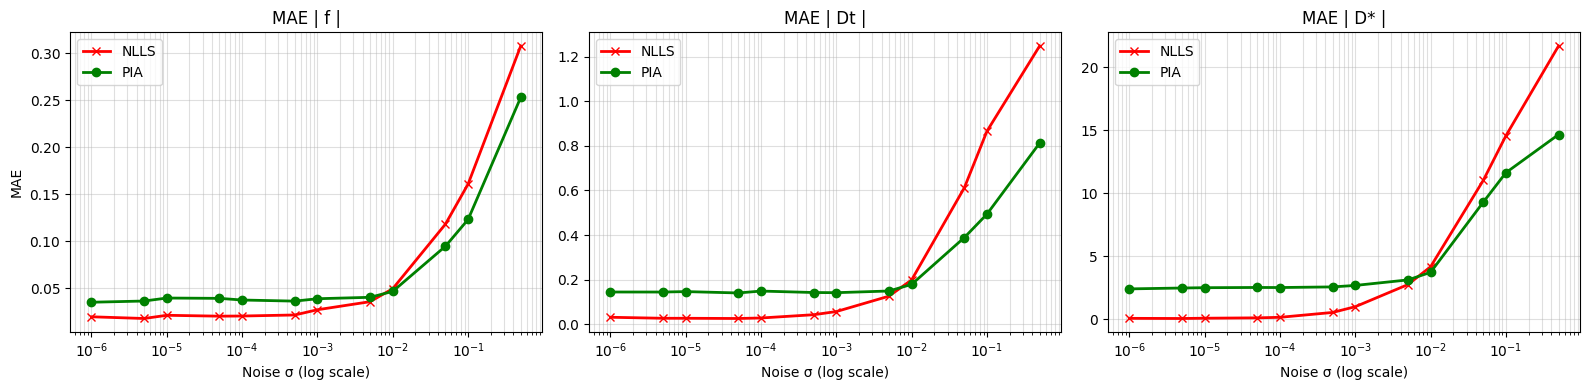

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# --- yardımcı ---
def mae(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    return np.mean(np.abs(a - b))

sigmas_sorted = sorted(sigmas)

# --- MAE dizilerini çıkar ---
mae_nlls_f, mae_nlls_dt, mae_nlls_ds = [], [], []
mae_pia_f,  mae_pia_dt,  mae_pia_ds  = [], [], []

for s in sigmas_sorted:
    f_gt  = batches[s]["f_gt"].detach().cpu().numpy().reshape(-1)
    dt_gt = batches[s]["Dt_gt"].detach().cpu().numpy().reshape(-1)
    ds_gt = batches[s]["Dstar_gt"].detach().cpu().numpy().reshape(-1)

    mae_nlls_f.append(mae(nlls_preds[s]["f"],     f_gt))
    mae_nlls_dt.append(mae(nlls_preds[s]["Dt"],   dt_gt))
    mae_nlls_ds.append(mae(nlls_preds[s]["Dstar"], ds_gt))

    mae_pia_f.append(mae(pia_preds[s]["f"],      f_gt))
    mae_pia_dt.append(mae(pia_preds[s]["Dt"],    dt_gt))
    mae_pia_ds.append(mae(pia_preds[s]["Dstar"], ds_gt))

# --- plot: yan yana 3 grafik ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

# f
axes[0].plot(sigmas_sorted, mae_nlls_f, marker='x', color='red',   linewidth=2, label='NLLS')
axes[0].plot(sigmas_sorted, mae_pia_f,  marker='o', color='green', linewidth=2, label='PIA')
axes[0].set_title("MAE | f |")
axes[0].set_xscale("log")
axes[0].set_ylabel("MAE")
axes[0].grid(True, which="both", alpha=0.4)
axes[0].legend()

# Dt
axes[1].plot(sigmas_sorted, mae_nlls_dt, marker='x', color='red',   linewidth=2, label='NLLS')
axes[1].plot(sigmas_sorted, mae_pia_dt,  marker='o', color='green', linewidth=2, label='PIA')
axes[1].set_title("MAE | Dt |")
axes[1].set_xscale("log")
axes[1].grid(True, which="both", alpha=0.4)
axes[1].legend()

# D*
axes[2].plot(sigmas_sorted, mae_nlls_ds, marker='x', color='red',   linewidth=2, label='NLLS')
axes[2].plot(sigmas_sorted, mae_pia_ds,  marker='o', color='green', linewidth=2, label='PIA')
axes[2].set_title("MAE | D* |")
axes[2].set_xscale("log")
axes[2].grid(True, which="both", alpha=0.4)
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Noise σ (log scale)")

plt.tight_layout()
plt.show()


In [42]:
# =========================
# 7) Readable Metrics Report: MAE + Spearman + Bias (Hybrid vs PIA) per sigma
# =========================
from scipy.stats import spearmanr

def _to_np_1d(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x).reshape(-1)

def mae_np(pred, gt):
    pred = _to_np_1d(pred)
    gt   = _to_np_1d(gt)
    return float(np.mean(np.abs(pred - gt)))

def bias_np(pred, gt):
    pred = _to_np_1d(pred)
    gt   = _to_np_1d(gt)
    return float(np.mean(pred - gt))

def spearman_np(pred, gt):
    pred = _to_np_1d(pred)
    gt   = _to_np_1d(gt)
    rho, _ = spearmanr(pred, gt)
    return float(rho) if rho is not None else np.nan

def fmt(x, w=10, p=6):
    return f"{x:{w}.{p}f}"

def fmt_signed(x, w=+10, p=6):
    return f"{x:{w}.{p}f}"

def fmt_triplet(a, b, c, p=6):
    return f"(f={a:.{p}f}, Dt={b:.{p}f}, D*={c:.{p}f})"

metrics = {}  # sigma -> dict

print("\n" + "="*110)
print("METRICS REPORT (Hybrid/NLLS vs PIA)  |  per sigma: MAE, Spearman rho, Bias")
print("="*110)

for s in sigmas:
    # GT
    f_gt  = _to_np_1d(batches[s]["f_gt"])
    Dt_gt = _to_np_1d(batches[s]["Dt_gt"])
    Ds_gt = _to_np_1d(batches[s]["Dstar_gt"])

    # Hybrid preds
    hf  = _to_np_1d(nlls_preds[s]["f"])
    hdt = _to_np_1d(nlls_preds[s]["Dt"])
    hds = _to_np_1d(nlls_preds[s]["Dstar"])

    # PIA preds
    pf  = _to_np_1d(pia_preds[s]["f"])
    pdt = _to_np_1d(pia_preds[s]["Dt"])
    pds = _to_np_1d(pia_preds[s]["Dstar"])

    # --- Hybrid metrics ---
    h_mae_f  = mae_np(hf,  f_gt)
    h_mae_dt = mae_np(hdt, Dt_gt)
    h_mae_ds = mae_np(hds, Ds_gt)

    h_rho_f  = spearman_np(hf,  f_gt)
    h_rho_dt = spearman_np(hdt, Dt_gt)
    h_rho_ds = spearman_np(hds, Ds_gt)

    h_bias_f  = bias_np(hf,  f_gt)
    h_bias_dt = bias_np(hdt, Dt_gt)
    h_bias_ds = bias_np(hds, Ds_gt)

    # --- PIA metrics ---
    p_mae_f  = mae_np(pf,  f_gt)
    p_mae_dt = mae_np(pdt, Dt_gt)
    p_mae_ds = mae_np(pds, Ds_gt)

    p_rho_f  = spearman_np(pf,  f_gt)
    p_rho_dt = spearman_np(pdt, Dt_gt)
    p_rho_ds = spearman_np(pds, Ds_gt)

    p_bias_f  = bias_np(pf,  f_gt)
    p_bias_dt = bias_np(pdt, Dt_gt)
    p_bias_ds = bias_np(pds, Ds_gt)

    metrics[s] = {
        "hybrid": {
            "mae":  {"f": h_mae_f,  "Dt": h_mae_dt, "Dstar": h_mae_ds},
            "rho":  {"f": h_rho_f,  "Dt": h_rho_dt, "Dstar": h_rho_ds},
            "bias": {"f": h_bias_f, "Dt": h_bias_dt,"Dstar": h_bias_ds},
            "time_s": float(nlls_times.get(s, np.nan))
        },
        "pia": {
            "mae":  {"f": p_mae_f,  "Dt": p_mae_dt, "Dstar": p_mae_ds},
            "rho":  {"f": p_rho_f,  "Dt": p_rho_dt, "Dstar": p_rho_ds},
            "bias": {"f": p_bias_f, "Dt": p_bias_dt,"Dstar": p_bias_ds},
            "time_s": float(pia_times.get(s, np.nan))
        }
    }

    print(f"\n--- sigma = {s:.1e} ---")

    print(f"Hybrid/NLLS | time = {metrics[s]['hybrid']['time_s']:.3f} s")
    print(f"  MAE   : {fmt_triplet(h_mae_f,  h_mae_dt,  h_mae_ds,  p=6)}")
    print(f"  rho   : {fmt_triplet(h_rho_f,  h_rho_dt,  h_rho_ds,  p=4)}")
    print(f"  bias  : {fmt_triplet(h_bias_f, h_bias_dt, h_bias_ds, p=6)}")

    print(f"PIA        | time = {metrics[s]['pia']['time_s']:.6f} s")
    print(f"  MAE   : {fmt_triplet(p_mae_f,  p_mae_dt,  p_mae_ds,  p=6)}")
    print(f"  rho   : {fmt_triplet(p_rho_f,  p_rho_dt,  p_rho_ds,  p=4)}")
    print(f"  bias  : {fmt_triplet(p_bias_f, p_bias_dt, p_bias_ds, p=6)}")

print("\n" + "="*110)
print("✅ 'metrics' dict is ready: metrics[sigma]['hybrid'/'pia']['mae'/'rho'/'bias'][param]")
print("="*110)



METRICS REPORT (Hybrid/NLLS vs PIA)  |  per sigma: MAE, Spearman rho, Bias

--- sigma = 1.0e-06 ---
Hybrid/NLLS | time = 9.597 s
  MAE   : (f=0.019761, Dt=0.031141, D*=0.087246)
  rho   : (f=0.9358, Dt=0.9735, D*=0.9999)
  bias  : (f=-0.016201, Dt=-0.016583, D*=0.085994)
PIA        | time = 0.095671 s
  MAE   : (f=0.035234, Dt=0.144493, D*=2.421300)
  rho   : (f=0.9502, Dt=0.9434, D*=0.9514)
  bias  : (f=0.006142, Dt=0.049196, D*=-0.393150)

--- sigma = 5.0e-06 ---
Hybrid/NLLS | time = 11.907 s
  MAE   : (f=0.017946, Dt=0.026573, D*=0.074885)
  rho   : (f=0.9395, Dt=0.9784, D*=0.9999)
  bias  : (f=-0.016335, Dt=-0.012861, D*=0.070195)
PIA        | time = 0.089727 s
  MAE   : (f=0.036516, Dt=0.144349, D*=2.490910)
  rho   : (f=0.9462, Dt=0.9444, D*=0.9443)
  bias  : (f=0.007464, Dt=0.051873, D*=-0.526732)

--- sigma = 1.0e-05 ---
Hybrid/NLLS | time = 10.819 s
  MAE   : (f=0.021353, Dt=0.026568, D*=0.096832)
  rho   : (f=0.9226, Dt=0.9797, D*=0.9999)
  bias  : (f=-0.018147, Dt=-0.018338

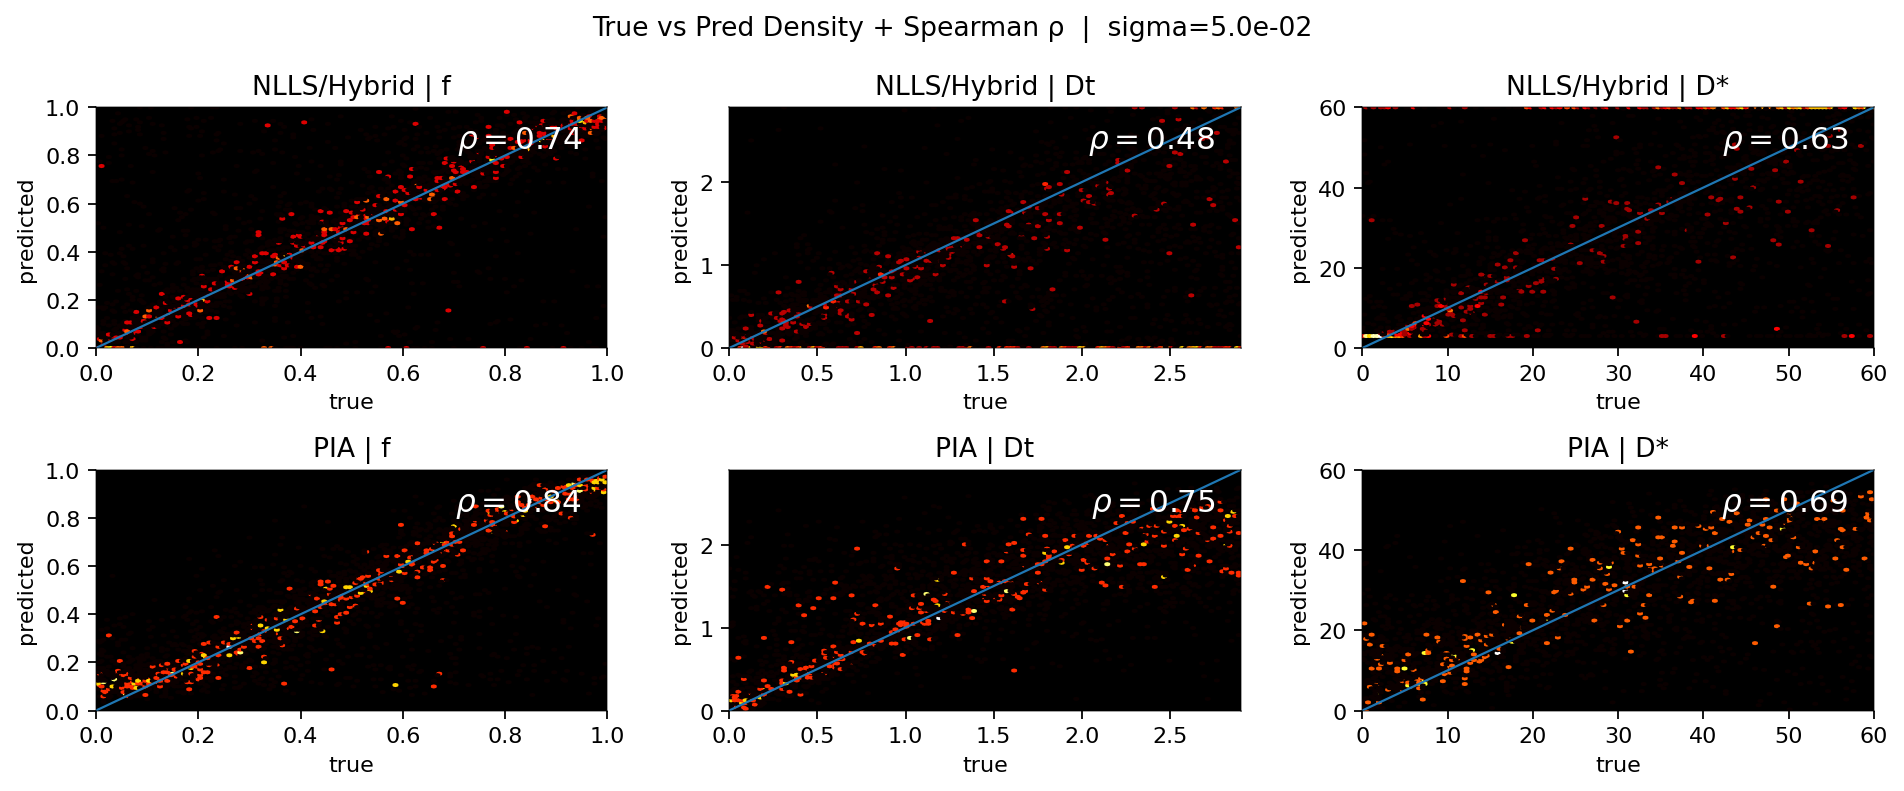

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.colors import LogNorm

# -----------------------------
# Choose which sigma to plot
# -----------------------------
sigma_to_plot = 5e-2   # <- change this (e.g., 1e-2, 5e-2, 1e-1, 5e-1)

# -----------------------------
# Helpers
# -----------------------------
def _np1(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x).reshape(-1)

def spearman_rho(x, y):
    rho, _ = spearmanr(_np1(x), _np1(y))
    return float(rho)

def density_panel(ax, x_true, y_pred, title, xlim=None, ylim=None, gridsize=140):
    x = _np1(x_true)
    y = _np1(y_pred)

    rho = spearman_rho(x, y)

    # Dark background + density
    ax.set_facecolor("black")
    hb = ax.hexbin(
        x, y,
        gridsize=gridsize,
        bins="log",           # log-counts
        mincnt=1,
        cmap="hot",           # similar look
    )

    # Optional identity line
    if xlim is None: xlim = (np.min(x), np.max(x))
    if ylim is None: ylim = (np.min(y), np.max(y))
    lo = max(min(xlim), min(ylim))
    hi = min(max(xlim), max(ylim))
    ax.plot([lo, hi], [lo, hi], linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("true")
    ax.set_ylabel("predicted")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # rho text (top-right)
    ax.text(
        0.95, 0.93, rf"$\rho={rho:.2f}$",
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=14,
        color="white"
    )

    # Remove heavy spines for clean look
    for spine in ax.spines.values():
        spine.set_alpha(0.4)

    return hb, rho

# -----------------------------
# Fetch data for selected sigma
# -----------------------------
s = sigma_to_plot

# Ground-truth
f_gt  = batches[s]["f_gt"]
Dt_gt = batches[s]["Dt_gt"]
Ds_gt = batches[s]["Dstar_gt"]

# Hybrid/NLLS preds
f_h  = nlls_preds[s]["f"]
Dt_h = nlls_preds[s]["Dt"]
Ds_h = nlls_preds[s]["Dstar"]

# PIA preds
f_p  = pia_preds[s]["f"]
Dt_p = pia_preds[s]["Dt"]
Ds_p = pia_preds[s]["Dstar"]

# Axis limits (use your known ranges)
xlim_f  = (0.0, 1.0);   ylim_f  = (0.0, 1.0)
xlim_dt = (0.0, 2.9);   ylim_dt = (0.0, 2.9)
xlim_ds = (0.0, 60.0);  ylim_ds = (0.0, 60.0)  # if D* starts at 3, you can set (3,60)

# -----------------------------
# Plot: 2 rows x 3 cols
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 5), dpi=160)
fig.suptitle(f"True vs Pred Density + Spearman ρ  |  sigma={s:.1e}", fontsize=12)

# Top row: Hybrid/NLLS
density_panel(axes[0,0], f_gt,  f_h,  "NLLS/Hybrid | f",     xlim_f,  ylim_f)
density_panel(axes[0,1], Dt_gt, Dt_h, "NLLS/Hybrid | Dt",    xlim_dt, ylim_dt)
density_panel(axes[0,2], Ds_gt, Ds_h, "NLLS/Hybrid | D*",    xlim_ds, ylim_ds)

# Bottom row: PIA
density_panel(axes[1,0], f_gt,  f_p,  "PIA | f",             xlim_f,  ylim_f)
density_panel(axes[1,1], Dt_gt, Dt_p, "PIA | Dt",            xlim_dt, ylim_dt)
density_panel(axes[1,2], Ds_gt, Ds_p, "PIA | D*",            xlim_ds, ylim_ds)

plt.tight_layout()
plt.show()


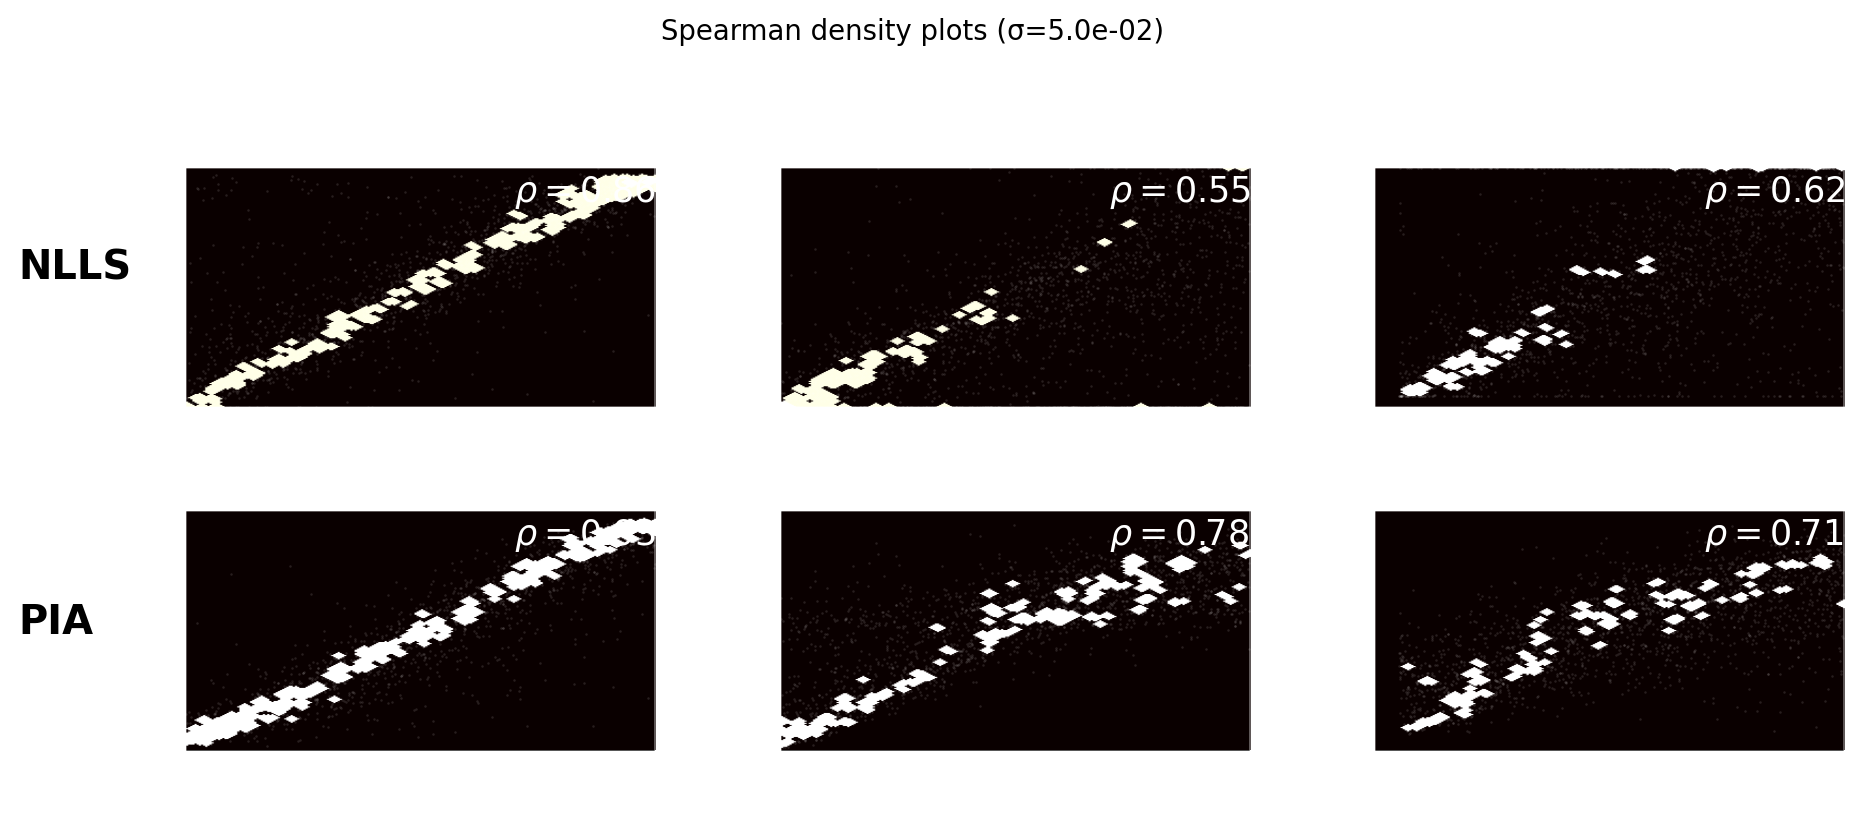

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.colors import LogNorm
from skimage import morphology  # <-- istediğin kısım

# -----------------------------
# Choose sigma to visualize
# -----------------------------
sigma_to_plot = 5e-2  # değiştir: 1e-2, 5e-2, 1e-1, 5e-1 ...

# -----------------------------
# Helpers
# -----------------------------
def _to_1d_np(x):
    try:
        import torch
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x).reshape(-1)

def _rho(x, y):
    r, _ = spearmanr(_to_1d_np(x), _to_1d_np(y))
    return float(r)

def morph_smooth_hist(H, radius=2, dilate=1):
    """
    Morphology-based smoothing:
    - closing: küçük boşlukları doldurur
    - opening: küçük gürültü piksellerini temizler
    - dilation: yoğun bölgeleri biraz 'parlatır/genişletir'
    """
    se = morphology.disk(radius)
    Hs = morphology.closing(H, se)
    Hs = morphology.opening(Hs, se)

    if dilate and dilate > 0:
        se2 = morphology.disk(dilate)
        Hs = morphology.dilation(Hs, se2)

    return Hs.astype(np.float32)

def density_scatter_morph(
    ax,
    x_true,
    y_pred,
    xlim,
    ylim,
    gridsize=220,
    morph_radius=2,
    morph_dilate=1,
    scatter_points=12000,
    title="",
):
    x = _to_1d_np(x_true)
    y = _to_1d_np(y_pred)

    # clip so histogram range is stable
    x = np.clip(x, xlim[0], xlim[1])
    y = np.clip(y, ylim[0], ylim[1])

    # 2D histogram
    H, _, _ = np.histogram2d(
        x, y,
        bins=gridsize,
        range=[xlim, ylim]
    )

    # morphology smoothing (instead of gaussian)
    Hs = morph_smooth_hist(H, radius=morph_radius, dilate=morph_dilate)

    ax.set_facecolor("black")

    # density image (log scale)
    eps = 1e-12
    ax.imshow(
        (Hs.T + eps),
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        norm=LogNorm(vmin=eps, vmax=np.max(Hs) + eps),
        cmap="hot",
        aspect="auto"
    )

    # overlay sparse white points
    if scatter_points and scatter_points > 0:
        n = x.shape[0]
        m = min(scatter_points, n)
        idx = np.random.choice(n, size=m, replace=False)
        ax.scatter(x[idx], y[idx], s=1, c="white", alpha=0.12, linewidths=0)

    r = _rho(x, y)
    ax.text(
        0.70, 0.86, rf"$\rho={r:.2f}$",
        transform=ax.transAxes,
        color="white",
        fontsize=14,
        fontweight="bold"
    )

    ax.set_title(title, color="white", fontsize=12, pad=8)
    ax.set_xlim(xlim); ax.set_ylim(ylim)

    ax.tick_params(colors="white", labelsize=8)
    for spine in ax.spines.values():
        spine.set_color("white")
        spine.set_alpha(0.35)

    ax.set_xlabel("true", color="white", fontsize=9)
    ax.set_ylabel("predicted", color="white", fontsize=9)

    return r

# -----------------------------
# Pull arrays
# -----------------------------
s = sigma_to_plot

f_gt  = batches[s]["f_gt"]
Dt_gt = batches[s]["Dt_gt"]
Ds_gt = batches[s]["Dstar_gt"]

# Hybrid/NLLS predictions
f_n  = nlls_preds[s]["f"]
Dt_n = nlls_preds[s]["Dt"]
Ds_n = nlls_preds[s]["Dstar"]

# PIA predictions
f_p  = pia_preds[s]["f"]
Dt_p = pia_preds[s]["Dt"]
Ds_p = pia_preds[s]["Dstar"]

# limits
xlim_f,  ylim_f  = (0.0, 1.0),  (0.0, 1.0)
xlim_dt, ylim_dt = (0.0, 2.9),  (0.0, 2.9)
xlim_ds, ylim_ds = (0.0, 60.0), (0.0, 60.0)

# -----------------------------
# Plot 2x3
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(10.8, 4.8), dpi=180)
fig.patch.set_facecolor("white")

# tweak these to match your look:
MORPH_RADIUS = 2   # 1-4 arası dene (büyüdükçe daha "smooth/glow")
MORPH_DILATE = 1   # 0-2 arası

density_scatter_morph(axes[0,0], f_gt,  f_n,  xlim_f,  ylim_f,  title="f",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)
density_scatter_morph(axes[0,1], Dt_gt, Dt_n, xlim_dt, ylim_dt, title="Dt",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)
density_scatter_morph(axes[0,2], Ds_gt, Ds_n, xlim_ds, ylim_ds, title="D*",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)

density_scatter_morph(axes[1,0], f_gt,  f_p,  xlim_f,  ylim_f,  title="",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)
density_scatter_morph(axes[1,1], Dt_gt, Dt_p, xlim_dt, ylim_dt, title="",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)
density_scatter_morph(axes[1,2], Ds_gt, Ds_p, xlim_ds, ylim_ds, title="",
                      morph_radius=MORPH_RADIUS, morph_dilate=MORPH_DILATE)

fig.text(0.04, 0.69, "NLLS", fontsize=16, fontweight="bold", va="center", ha="left")
fig.text(0.04, 0.28, "PIA",  fontsize=16, fontweight="bold", va="center", ha="left")

fig.suptitle(f"Spearman density plots (σ={s:.1e})", fontsize=11, y=0.98)
plt.tight_layout(rect=[0.07, 0.02, 1, 0.95])
plt.show()
